<a href="https://colab.research.google.com/github/vivek6311/Artificial-Intelligence-with-Python/blob/master/Mizoram_PES_IPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os

In [38]:
df= pd.read_excel('/content/PES IPD.xlsx')

In [39]:
df.head()

,Sl.No,Type,Facility Name,Type of Unit,Age of the Patient\n,What was the total monthly expenditure on health of all members in the family?,Distance from residence to Health Care Facility,Gender,Frequency of visit to the Health Care Facility,Why did you choose to visit this Health Care Facility?,...,Was there any occasion where you felt that the health care staff behaved inappropriately?,"According to you, how often is your room/ ward kept clean by hospital staff?","According to you, how clean are the toilets in your ward/room in the hospital staff?","During this hospital stay, did you receive food/ meals every day from the hospital?",Were any tests performed on you during this stay at the hospital or elsewhere?\n\nHemi damdawiin emaw hmundang a I awmlaiin I natna chungchangah enfiah I ni tawh em?,"At the health facility were there clear signs and labels to show directions (for areas such as waiting room, examination room, labs, etc)",Are you satisfied with the services provided in the hospital?,Do you feel the cost of treatment was.,Are you enrolled in any Government insurance?,Unnamed: 42
0,1,PHC,Haulawng PHC,General Medicine,35,2500,2.0,F,2,Near to residence,...,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes,NaN
1,2,PHC,Kawnpui PHC,General Medicine,30,3000,2.0,F,2,Near to residence,...,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes,NaN
2,3,PHC,Khawlailung PHC,General Medicine,52,5000,5.0,F,2,Near to residence,...,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes,NaN
3,4,PHC,Lengpui PHC,General Medicine,24,3000,2.0,F,2,Near to residence,...,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes,NaN
4,5,CHC,Vairengte CHC,General Medicine,34,10000,4.0,M,1,Near to residence,...,Never,Once everyday,Clean,Yes,No,Yes,Yes,Very expensive,No,NaN


In [40]:
# 2. INITIAL DATA PREP
# Drop unnamed columns & fill missing header if necessary
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # remove unnamed columns

In [41]:
df.head()

,Sl.No,Type,Facility Name,Type of Unit,Age of the Patient\n,What was the total monthly expenditure on health of all members in the family?,Distance from residence to Health Care Facility,Gender,Frequency of visit to the Health Care Facility,Why did you choose to visit this Health Care Facility?,...,Did the doctor/staff answer your questions politely and respectfully in a way which was helpful for you?,Was there any occasion where you felt that the health care staff behaved inappropriately?,"According to you, how often is your room/ ward kept clean by hospital staff?","According to you, how clean are the toilets in your ward/room in the hospital staff?","During this hospital stay, did you receive food/ meals every day from the hospital?",Were any tests performed on you during this stay at the hospital or elsewhere?\n\nHemi damdawiin emaw hmundang a I awmlaiin I natna chungchangah enfiah I ni tawh em?,"At the health facility were there clear signs and labels to show directions (for areas such as waiting room, examination room, labs, etc)",Are you satisfied with the services provided in the hospital?,Do you feel the cost of treatment was.,Are you enrolled in any Government insurance?
0,1,PHC,Haulawng PHC,General Medicine,35,2500,2.0,F,2,Near to residence,...,Usually,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes
1,2,PHC,Kawnpui PHC,General Medicine,30,3000,2.0,F,2,Near to residence,...,Usually,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes
2,3,PHC,Khawlailung PHC,General Medicine,52,5000,5.0,F,2,Near to residence,...,Usually,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes
3,4,PHC,Lengpui PHC,General Medicine,24,3000,2.0,F,2,Near to residence,...,Usually,Never,Once everyday,Clean,Yes,No,Yes,Yes,Somewhat expensive,Yes
4,5,CHC,Vairengte CHC,General Medicine,34,10000,4.0,M,1,Near to residence,...,Sometimes,Never,Once everyday,Clean,Yes,No,Yes,Yes,Very expensive,No


In [42]:
# Set which columns to treat specially
first_5 = df.columns[:7]       # Meta columns
data_cols = df.columns[7:]     # All columns from 6th onward, as per your instructions

In [44]:
# 3. DATA CLEANING & ENCODING
df_data = df[data_cols].copy()
df_data = df_data.astype(str)   # Convert all to string for one-hot encoding


In [45]:
# One-hot encode ALL non-numeric columns in the selected data
df_oh = pd.get_dummies(df_data)

In [46]:
# Optional: Remove columns with only one unique value (not informative)
df_oh = df_oh.loc[:, df_oh.nunique() > 1]

In [47]:
# Impute any NaNs (should be none after get_dummies, but just in case)
df_oh = df_oh.fillna(0)

In [49]:
# Save the one-hot encoded full dataset
df_oh.to_excel("PES_IPD_encoded_data.xlsx", index=False)

In [56]:
# 3. DATA VISUALISATION (as before)
corr_matrix = df_oh.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.5},
            xticklabels=False, yticklabels=False)
plt.title("Correlation Heatmap of Encoded Features")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.close()

# 4. ITERATIVE PCA + CLUSTERING + EXPORTS
iterations = 3
top_features = 15
n_components_pca = 5
n_clusters = 3

current_df = df_oh.copy()
important_features_all = []
pc_loadings_all = []

os.makedirs("iteration_outputs", exist_ok=True)

for i in range(iterations):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(current_df)
    pca = PCA(n_components=n_components_pca)
    X_pca = pca.fit_transform(X_scaled)

    # Save explained variance plot
    plt.figure()
    plt.bar(range(1, n_components_pca + 1), pca.explained_variance_ratio_)
    plt.xlabel('PCA Component')
    plt.ylabel('Explained Variance')
    plt.title(f'Iteration {i+1} - Explained Variance by Component')
    plt.tight_layout()
    plt.savefig(f"iteration_outputs/iter_{i+1}_explained_variance.png")
    plt.close()

    # Clustering (KMeans)
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = km.fit_predict(X_pca)
    current_df["Cluster"] = clusters  # temporarily add for saving

    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title(f'Iteration {i+1} - KMeans Clusters in PCA space')
    plt.tight_layout()
    plt.savefig(f"iteration_outputs/iter_{i+1}_kmeans_clusters.png")
    plt.close()

    # Save cluster labels file
    current_df[["Cluster"]].to_csv(f"iteration_outputs/iter_{i+1}_clusters.csv")

    # Find the top features contributing to all PCs
    loadings = pd.DataFrame(pca.components_.T,
                            columns=[f"PC{j+1}" for j in range(n_components_pca)],
                            index=current_df.drop('Cluster', axis=1).columns)  # drop temp Cluster
    important_features = set()
    pca_feature_scores = []

    for pc in loadings.columns:
        feats = loadings[pc].abs().sort_values(ascending=False).head(top_features)
        important_features.update(feats.index)
        for name, score in feats.items():
            pca_feature_scores.append({"Iteration": i+1, "PC": pc, "Feature": name, "Abs_Loading": score})

    # Save PCA loadings per-iteration
    loadings.to_csv(f"iteration_outputs/iter_{i+1}_pca_loadings.csv")

    # Save top PCA features with scores per-iteration
    pd.DataFrame(pca_feature_scores).to_csv(f"iteration_outputs/iter_{i+1}_top_pca_features.csv", index=False)

    important_features_all.append(list(important_features))
    pc_loadings_all.extend(pca_feature_scores)

    current_df = current_df[list(important_features)]  # next round, just keep important
    # Remove Cluster col if present
    if 'Cluster' in current_df.columns:
        current_df = current_df.drop('Cluster', axis=1)

# FINAL: Save final important features and PCA scores
final_features = current_df.columns.tolist()
pd.Series(final_features, name="FinalImportantFeatures").to_csv("final_important_features.csv", index=False)
pd.DataFrame(pc_loadings_all).to_csv("all_iterations_important_pca_features.csv", index=False)

print("✅ All files saved:")
print("- one_hot_encoded_data.xlsx")
print("- correlation_heatmap.png")
print("- iteration_outputs/ (per-iteration PCA loadings, clustering, feature scores, variance, clusters plots)")
print("- final_important_features.csv")
print("- all_iterations_important_pca_features.csv")

/tmp/ipython-input-56-1571031778.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df["Cluster"] = clusters  # temporarily add for saving


✅ All files saved:
- one_hot_encoded_data.xlsx
- correlation_heatmap.png
- iteration_outputs/ (per-iteration PCA loadings, clustering, feature scores, variance, clusters plots)
- final_important_features.csv
- all_iterations_important_pca_features.csv


Top 10 features: ['Did the doctor/nurse discuss your condition/symptoms and treatment with you in a way you could understand?_Always', 'Did the doctor/nurse discuss your condition/symptoms and treatment with you in a way you could understand?_Usually', 'Why did you choose to visit this Health Care Facility?_Near to Residence', 'Are all the medicines prescribed by the doctor available in the health facility?_nan', 'At any point during your stay were you left unattended by health providers when you needed care?_No', 'At any point during your stay were you left unattended by health providers when you needed care?_Yes', 'Are all the medicines prescribed by the doctor available in the health facility?_Some', 'When the doctor visits you, how often do they check your file/ updates?_Usually', 'When the doctor visits you, how often do they ask how you are feeling and listen to your questions and cocnerns?_Usually', 'When the doctor visits you, how often do they ask how you are feeling and liste

/tmp/ipython-input-57-3239430084.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


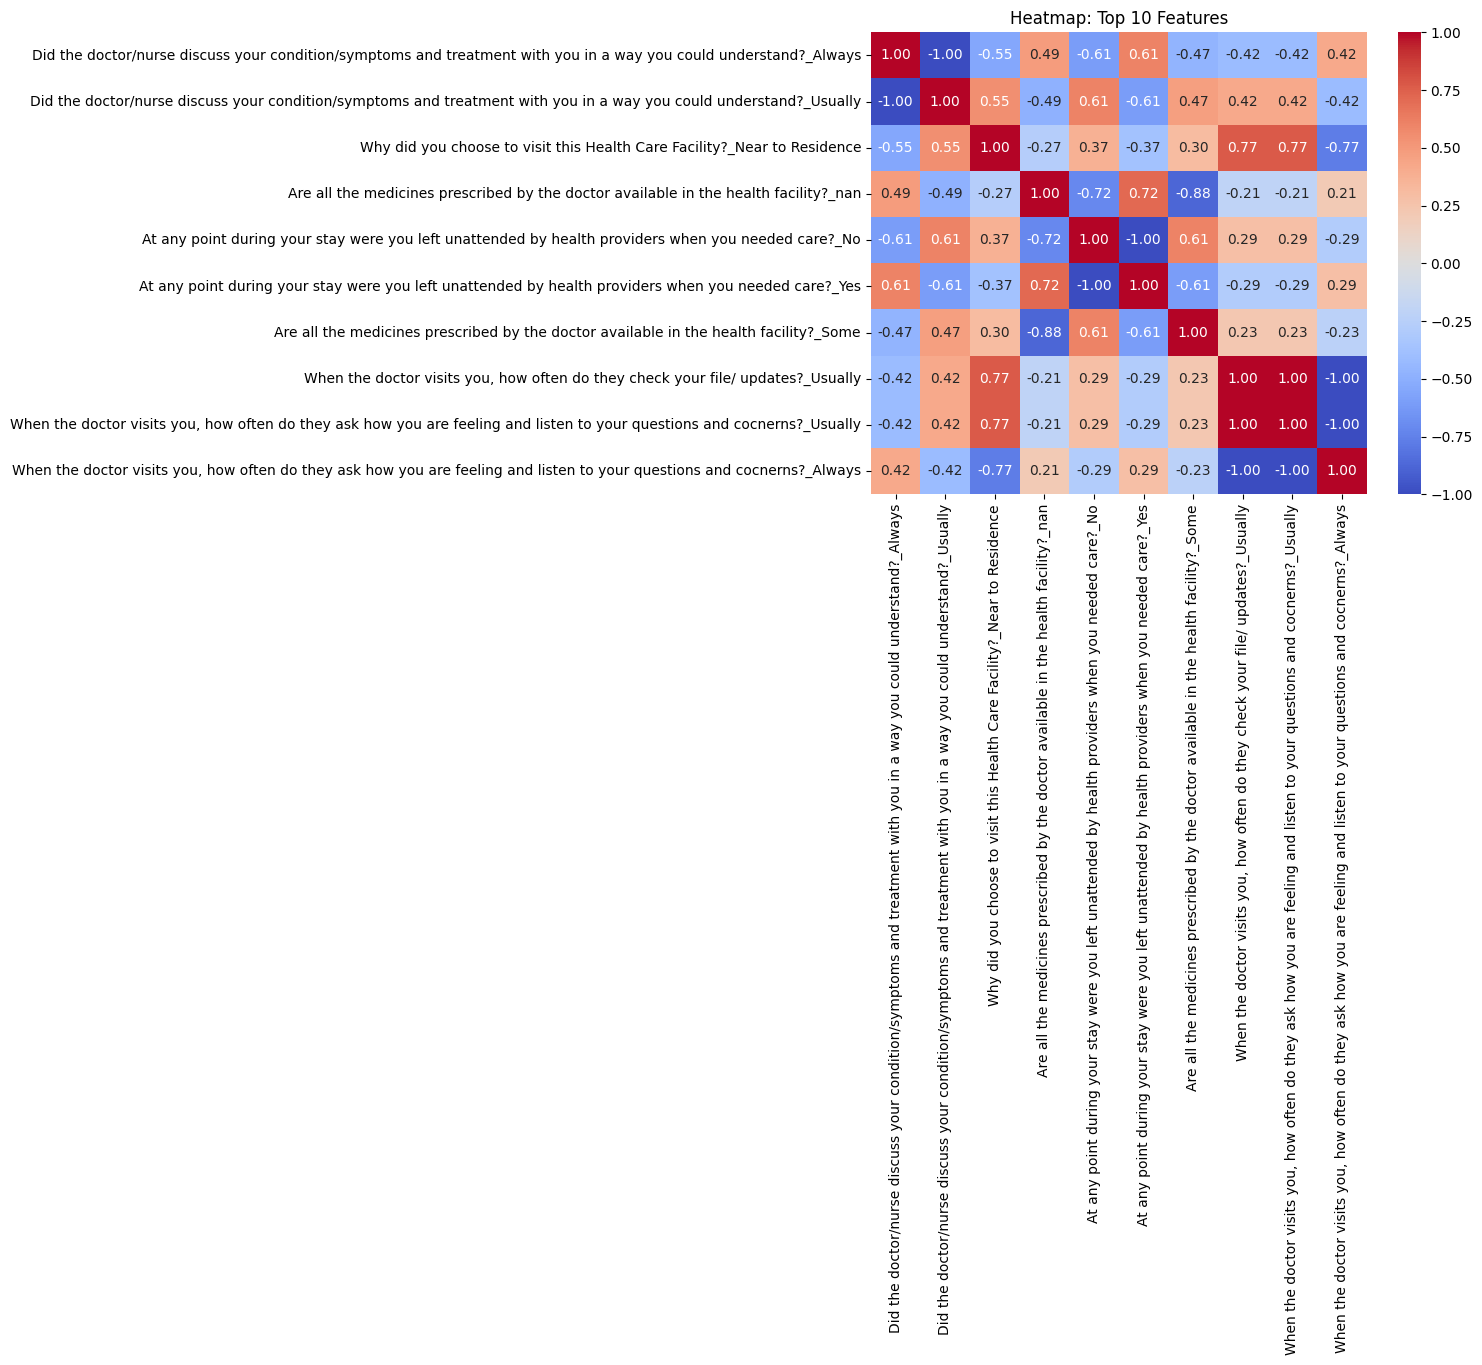

/tmp/ipython-input-57-3239430084.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


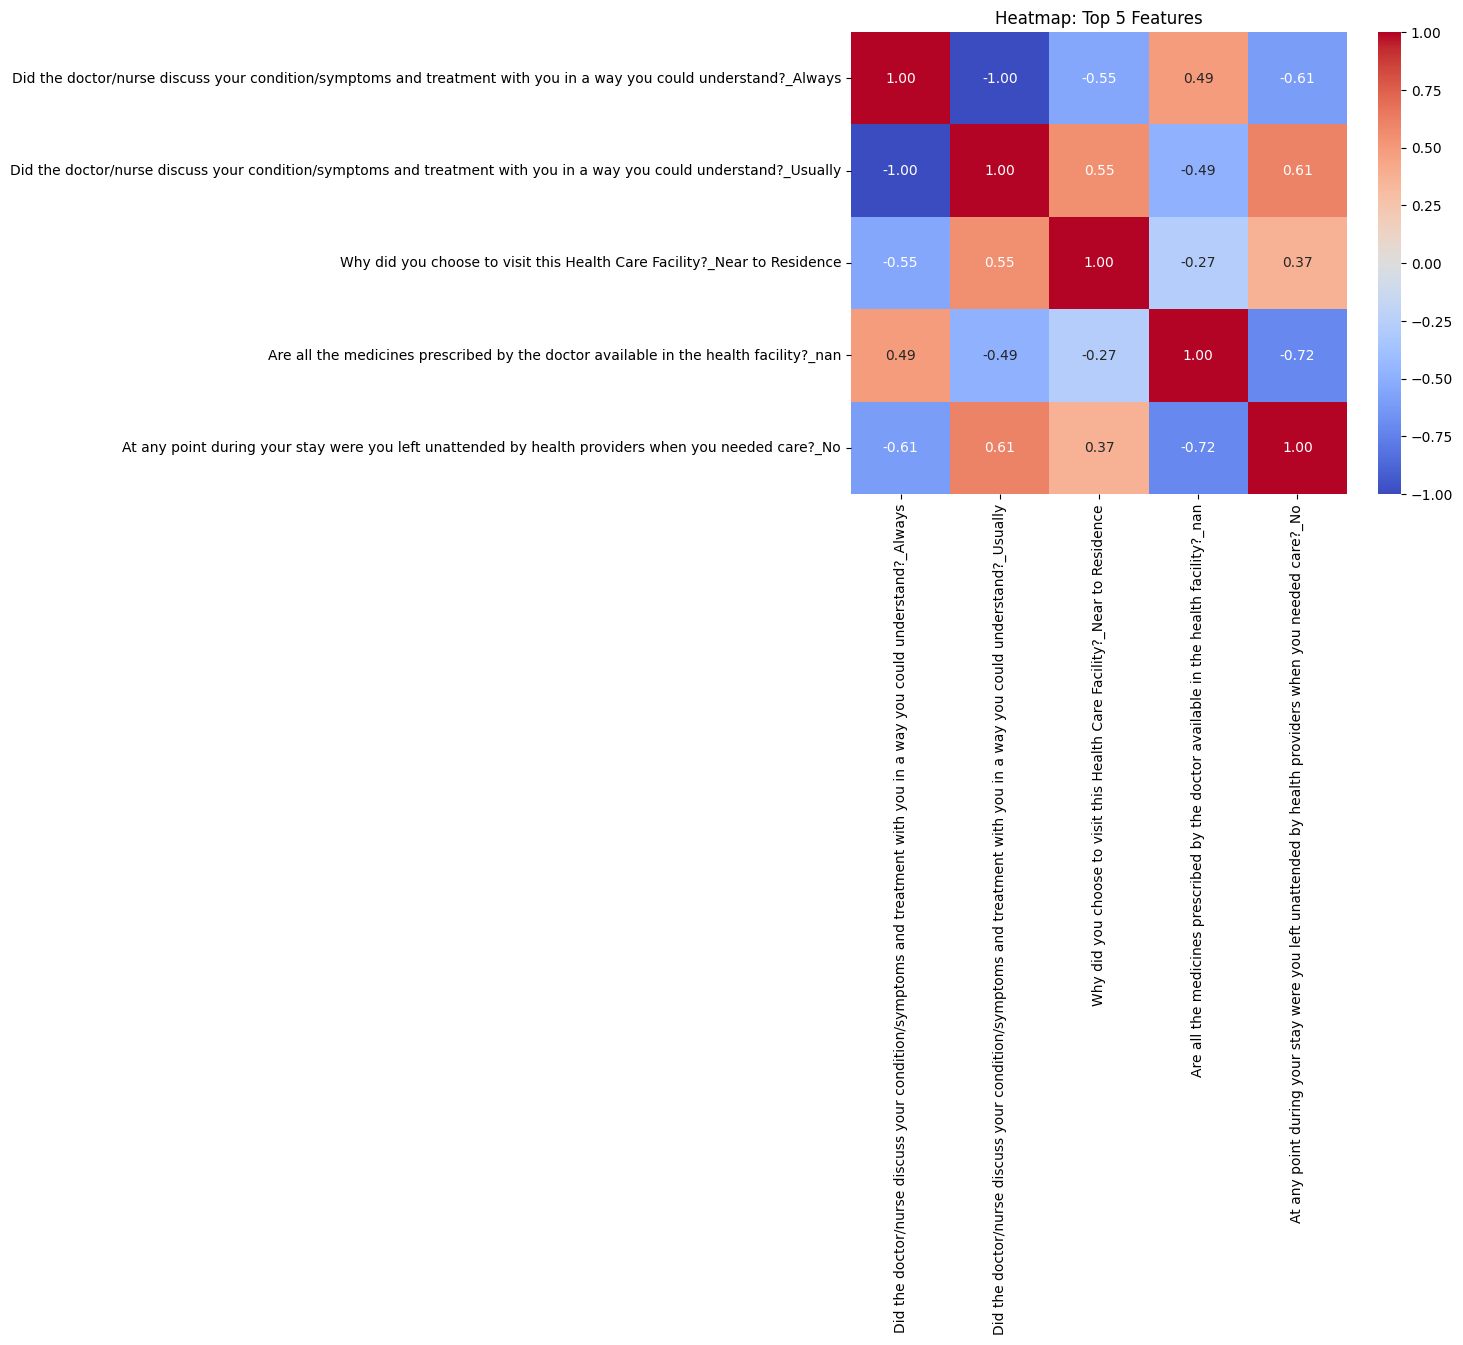

/tmp/ipython-input-57-3239430084.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


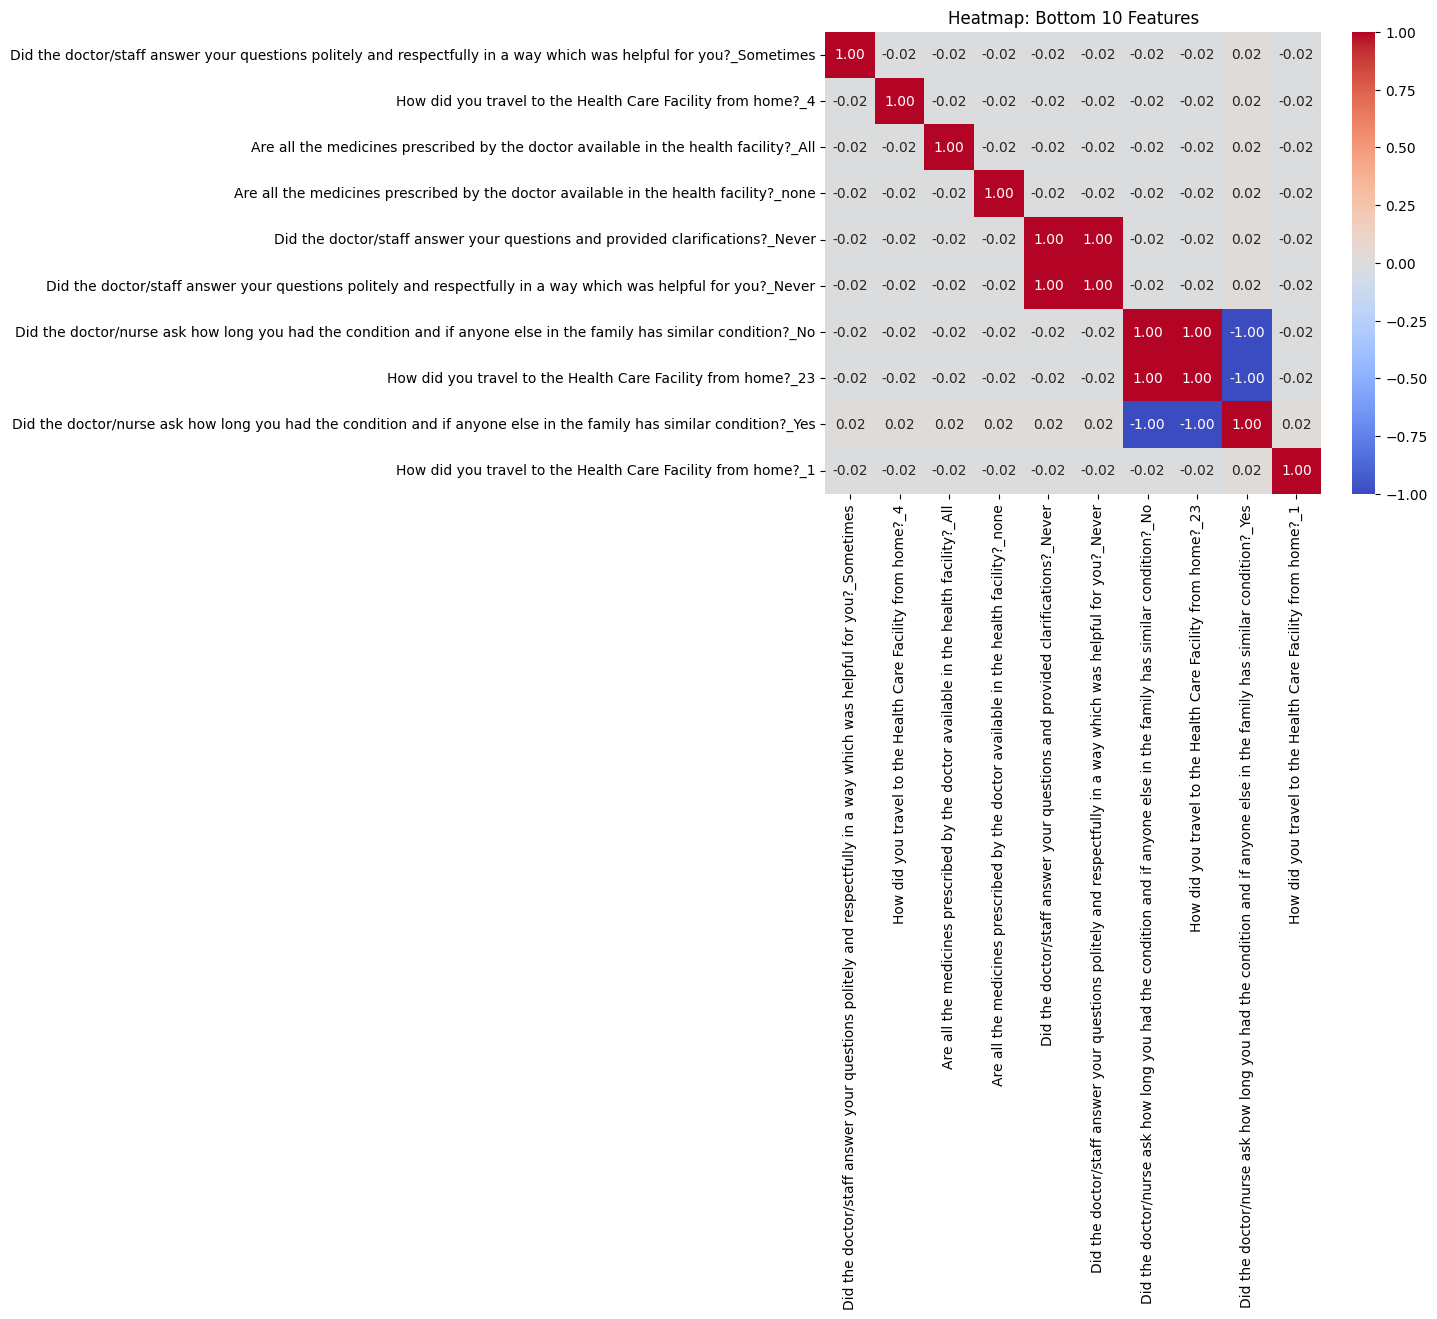

/tmp/ipython-input-57-3239430084.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


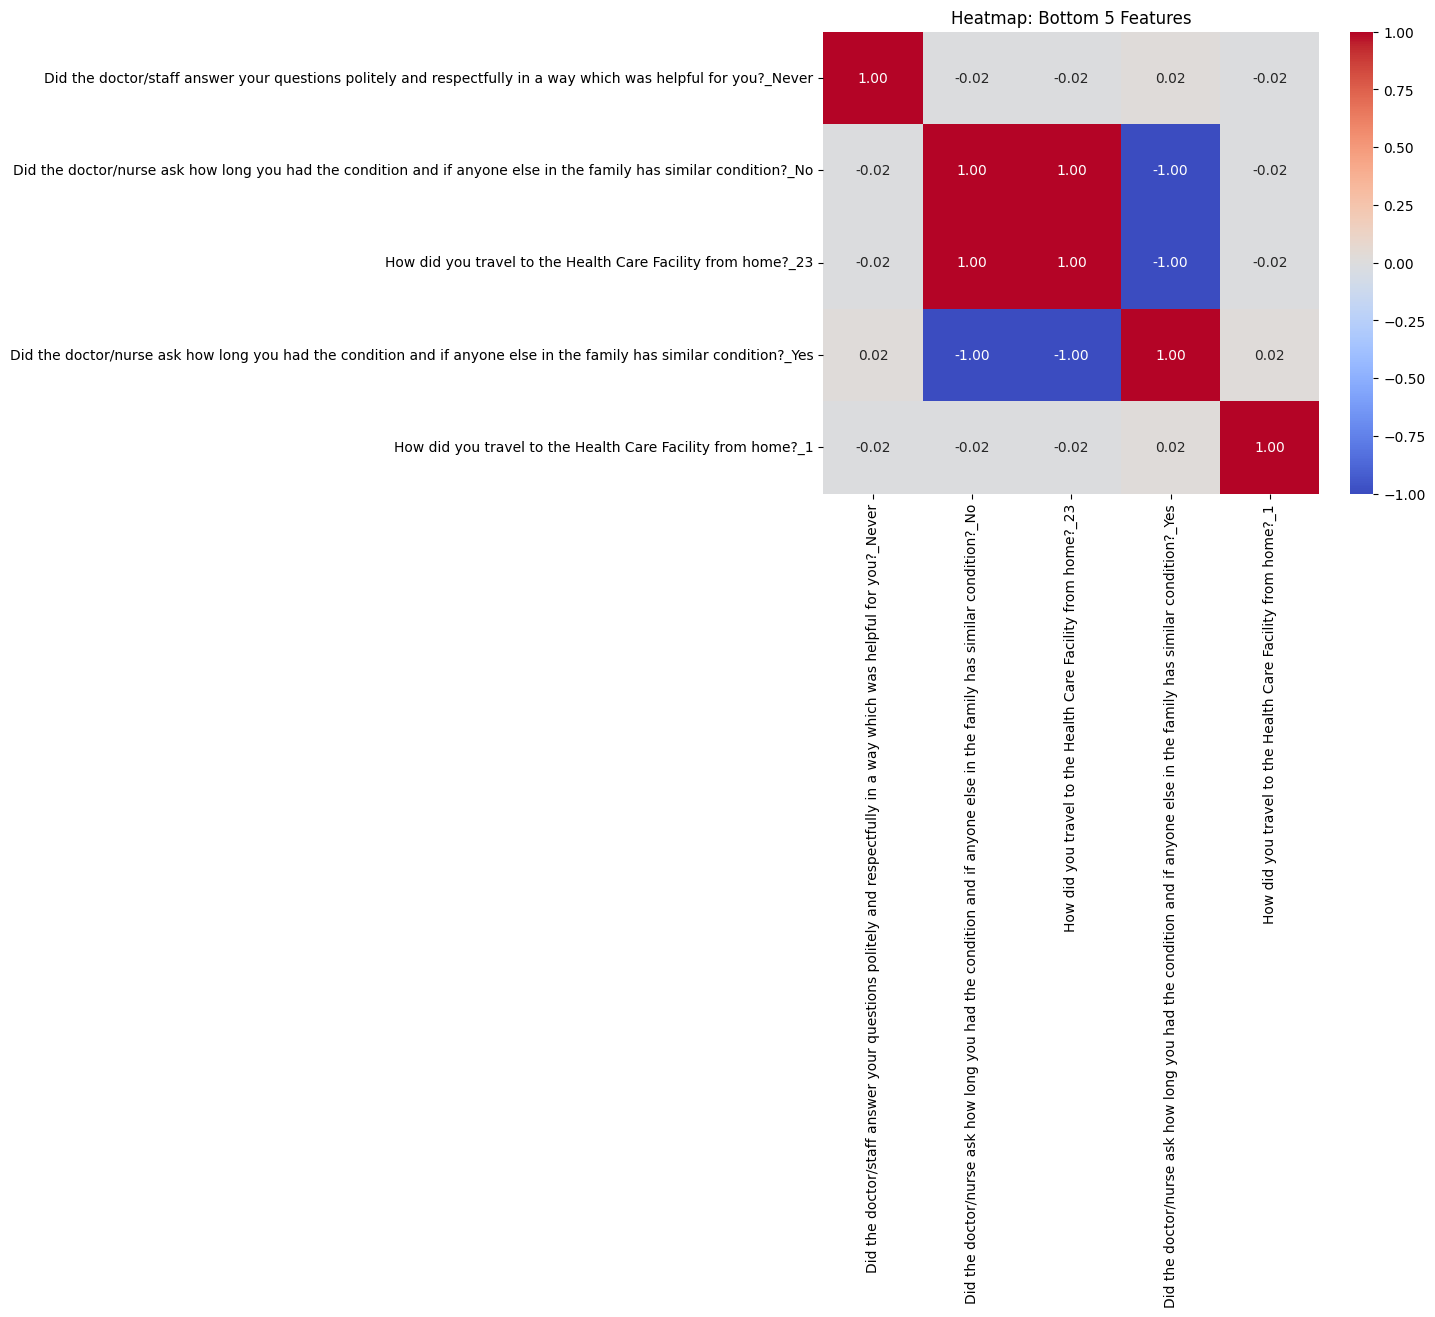

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate correlation matrix
corr_matrix = df_oh.corr()

# 2. Compute mean absolute correlation for each feature (excluding self-correlation)
mean_abs_corr = corr_matrix.abs().replace(1, np.nan).mean().sort_values(ascending=False)

# 3. Identify feature lists
top_10 = mean_abs_corr.head(10).index.tolist()
top_5 = mean_abs_corr.head(5).index.tolist()
bottom_10 = mean_abs_corr.tail(10).index.tolist()
bottom_5 = mean_abs_corr.tail(5).index.tolist()

# 4. Print feature lists
print("Top 10 features:", top_10)
print("Top 5 features:", top_5)
print("Bottom 10 features:", bottom_10)
print("Bottom 5 features:", bottom_5)

# 5. Print correlation matrices for top/bottom features
print("\nCorrelation matrix for Top 10 features:")
print(corr_matrix.loc[top_10, top_10])
print("\nCorrelation matrix for Top 5 features:")
print(corr_matrix.loc[top_5, top_5])
print("\nCorrelation matrix for Bottom 10 features:")
print(corr_matrix.loc[bottom_10, bottom_10])
print("\nCorrelation matrix for Bottom 5 features:")
print(corr_matrix.loc[bottom_5, bottom_5])

# 6. Heatmap plotting function
def plot_heatmap(feature_list, matrix, title):
    plt.figure(figsize=(8,6))
    subset = matrix.loc[feature_list, feature_list]
    sns.heatmap(subset, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 7. Draw all requested heatmaps
plot_heatmap(top_10, corr_matrix, "Heatmap: Top 10 Features")
plot_heatmap(top_5, corr_matrix, "Heatmap: Top 5 Features")
plot_heatmap(bottom_10, corr_matrix, "Heatmap: Bottom 10 Features")
plot_heatmap(bottom_5, corr_matrix, "Heatmap: Bottom 5 Features")

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Calculate correlation matrix and mean absolute correlations
corr_matrix = df_oh.corr()
mean_abs_corr = corr_matrix.abs().replace(1, np.nan).mean().sort_values(ascending=False)

# Identify feature lists
top_10 = mean_abs_corr.head(10).index.tolist()
top_5 = mean_abs_corr.head(5).index.tolist()
bottom_10 = mean_abs_corr.tail(10).index.tolist()
bottom_5 = mean_abs_corr.tail(5).index.tolist()

def wrap_labels(labels, width=16):
    return ['\n'.join(textwrap.wrap(str(label), width)) for label in labels]

# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(30,30))
feature_sets = [(top_10, "Top 10 Features"),
                (top_5, "Top 5 Features"),
                (bottom_10, "Bottom 10 Features"),
                (bottom_5, "Bottom 5 Features")]

for ax, (feature_list, title) in zip(axs.flat, feature_sets):
    wrapped_labels = wrap_labels(feature_list)
    subset = corr_matrix.loc[feature_list, feature_list]
    sns.heatmap(subset, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                xticklabels=wrapped_labels, yticklabels=wrapped_labels, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.savefig("correlation_heatmaps_all.png", dpi=300)   # Save as PNG
plt.savefig("correlation_heatmaps_all.pdf")            # Or as PDF for high quality
plt.close()

print("✅ All four heatmaps have been saved together in 'correlation_heatmaps_all.png' and 'correlation_heatmaps_all.pdf'.")


✅ All four heatmaps have been saved together in 'correlation_heatmaps_all.png' and 'correlation_heatmaps_all.pdf'.
